Analyzing GloVe word embeddings dataset using high-dim tools.

In [1]:
import gensim.downloader as api

kv = api.load('glove-wiki-gigaword-300') # ~400k words × 300D

Creating sub-groups.

In [2]:
import json

# Load groups
with open("word_groups.json", "r", encoding="utf-8") as f:
    groups = json.load(f)

# remove duplicates + preserve order
def dedup(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

# intersect with kv and dedup
def present_in_kv(words, kv):
    return [w for w in dedup(words) if w in kv.key_to_index]

rank = {w: i for i, w in enumerate(kv.index_to_key)}
for k in groups:
    groups[k] = present_in_kv(groups[k], kv)
    groups[k] = sorted(groups[k], key=lambda w: rank.get(w, 10**9))

# Show summary
for name, lst in groups.items():
    print(f"{name:12}: {len(lst):4d} | sample: {lst[:10]}")

animals     :  169 | sample: ['turkey', 'fox', 'cricket', 'horse', 'dog', 'ray', 'bear', 'tiger', 'chicken', 'buffalo']
tools       :  114 | sample: ['level', 'saw', 'square', 'plane', 'bit', 'jack', 'die', 'file', 'camera', 'monitor']
professions :  114 | sample: ['director', 'secretary', 'coach', 'manager', 'judge', 'attorney', 'professor', 'lawyer', 'guard', 'model']
body_parts  :  134 | sample: ['back', 'head', 'face', 'hand', 'heart', 'blood', 'eye', 'foot', 'leg', 'temple']
fruits      :  128 | sample: ['date', 'rice', 'orange', 'apple', 'corn', 'wheat', 'pepper', 'olive', 'garlic', 'cherry']


PCA Based ID

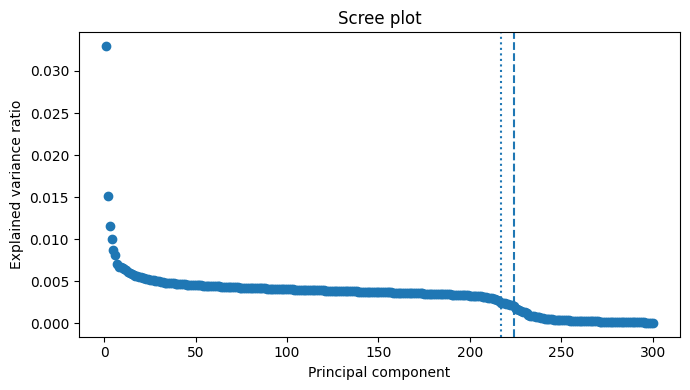

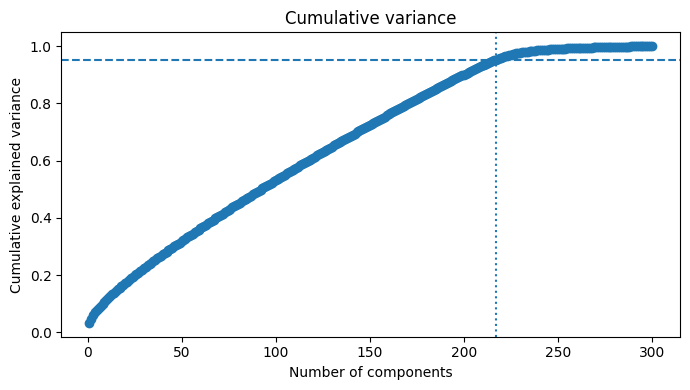

ID @ 95% variance: 217
Elbow estimate:    224


In [3]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_id(kv, words=None, plot=False, target=0.95, random_state=42):
    """
    PCA-based intrinsic dimension.
    - kv: gensim KeyedVectors
    - words: optional list of tokens in kv; if None, uses entire vocab
    - plot: if True, show scree + cumulative variance plots
    Returns: (id95, elbow)
    """
    # Build matrix
    if words is None:
        words = kv.index_to_key  # whole vocab
    X = np.vstack([kv[w] for w in words if w in kv.key_to_index]).astype("float32")
    X /= np.linalg.norm(X, axis=1, keepdims=True) + 1e-12

    # PCA (always up to 300 comps, bounded by n and d)
    n_components = min(300, X.shape[1], X.shape[0])
    pca = PCA(n_components=n_components, svd_solver="randomized", random_state=random_state)
    _ = pca.fit_transform(X)

    expl_var = pca.explained_variance_
    expl_var_ratio = pca.explained_variance_ratio_
    cumvar = np.cumsum(expl_var_ratio)

    # ID at 95% variance
    id95 = int(np.searchsorted(cumvar, target) + 1)

    # Elbow via two-segment fit on log-eigenvalues
    def two_segment_elbow(eigs):
        y = np.log(eigs + 1e-12)
        x = np.arange(1, len(y) + 1, dtype=float)
        best_sse, best_k = np.inf, None
        for split in range(3, len(y) - 2):  # ≥3 points per segment
            xl, yl = x[:split], y[:split]
            xr, yr = x[split:], y[split:]
            pl = np.polyfit(xl, yl, 1); yl_hat = np.polyval(pl, xl)
            pr = np.polyfit(xr, yr, 1); yr_hat = np.polyval(pr, xr)
            sse = ((yl - yl_hat)**2).sum() + ((yr - yr_hat)**2).sum()
            if sse < best_sse:
                best_sse, best_k = sse, split
        return best_k

    elbow = two_segment_elbow(expl_var)

    if plot:
        # Scree
        plt.figure(figsize=(7,4))
        plt.plot(np.arange(1, len(expl_var_ratio)+1), expl_var_ratio, marker='o', linestyle='none')
        plt.axvline(id95, linestyle=':')
        if elbow is not None: plt.axvline(elbow, linestyle='--')
        plt.xlabel("Principal component"); plt.ylabel("Explained variance ratio")
        plt.title("Scree plot"); plt.tight_layout(); plt.show()

        # Cumulative
        plt.figure(figsize=(7,4))
        plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='o')
        plt.axhline(target, linestyle='--'); plt.axvline(id95, linestyle=':')
        plt.xlabel("Number of components"); plt.ylabel("Cumulative explained variance")
        plt.title("Cumulative variance"); plt.tight_layout(); plt.show()

    return id95, elbow

# Whole vocabulary with plots
id95_all, elbow_all = pca_id(kv, words=None, plot=True)
print("ID @ 95% variance:", id95_all)
print("Elbow estimate:   ", elbow_all)

In [4]:
# Run PCA ID + elbow for all sub-groups
for name, wordlist in groups.items():
    id95, elbow = pca_id(kv, words=wordlist, plot=False)
    print(f"Subset: {name.capitalize()}")
    print(f"  ID @ 95% variance: {id95}")
    print(f"  Elbow estimate:    {elbow}\n")

Subset: Animals
  ID @ 95% variance: 107
  Elbow estimate:    166

Subset: Tools
  ID @ 95% variance: 84
  Elbow estimate:    111

Subset: Professions
  ID @ 95% variance: 77
  Elbow estimate:    111

Subset: Body_parts
  ID @ 95% variance: 87
  Elbow estimate:    131

Subset: Fruits
  ID @ 95% variance: 85
  Elbow estimate:    125



KNN Based Method.

In [ ]:
import numpy as np
from typing import Iterable, Optional, Tuple, Dict, List, Union
from sklearn.neighbors import NearestNeighbors

# ---------------------------
# Helpers
# ---------------------------
def _vecs_from_kv(
    kv,
    words: Optional[Iterable[str]] = None,
    normalize: bool = True,
) -> Tuple[np.ndarray, List[str]]:
    """Extract vectors from gensim KeyedVectors; filter OOV; optional L2-normalize."""
    if words is None:
        vocab = list(kv.key_to_index.keys())
    else:
        vocab = [w for w in words if w in kv]
    if not vocab:
        raise ValueError("No in-vocabulary words found.")
    X = np.vstack([kv[w] for w in vocab]).astype(np.float64)
    if normalize:
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        X = X / norms
    return X, vocab

def _lb_mle_point(d: np.ndarray) -> float:
    """
    Levina–Bickel per-point MLE given sorted neighbor distances d (length k, exclude self).
    m_hat = [ (1/(k-1)) * sum_{j=1..k-1} log(d_k / d_j) ]^{-1}
    """
    if len(d) < 2:
        return np.nan
    # guard against zeros/duplicates
    eps = 1e-12
    dk = max(d[-1], eps)
    dj = np.maximum(d[:-1], eps)
    s = np.mean(np.log(dk / dj))
    if not np.isfinite(s) or s <= 0:
        return np.nan
    return 1.0 / s

def _lb_mle_global(X: np.ndarray, k: int, metric: str = "euclidean") -> float:
    """
    Global ID: average of per-point MLEs using k neighbors (excluding self).
    Uses k+1 in query to drop the zero self-distance cleanly.
    """
    if X.shape[0] <= k:
        raise ValueError(f"k={k} requires > {k} samples; got {X.shape[0]}.")
    nn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm="auto")
    nn.fit(X)
    dists, _ = nn.kneighbors(X, return_distance=True)
    dists = dists[:, 1:]  # drop self (0), keep k neighbors; each row sorted asc
    ids = np.apply_along_axis(_lb_mle_point, 1, dists)
    ids = ids[np.isfinite(ids)]
    return float(np.mean(ids)) if ids.size else np.nan

# ---------------------------
# Public API
# ---------------------------
def knn_id(
    kv,
    words: Optional[Iterable[str]] = None,
    *,
    k: Optional[int] = None,
    k_min: int = 5,
    k_max: int = 30,
    metric: str = "euclidean",
    normalize: bool = True,
    max_points: int = 50000,
    random_state: int = 0,
) -> Tuple[float, Dict[int, float]]:
    """
    Levina–Bickel (2005) KNN MLE intrinsic dimension.

    If k is None: average over k in [k_min, k_max] and return (avg, {k: id_k}).
    If k is provided: return (id_k, {k: id_k}).

    Notes:
    - For very large vocabularies, we subsample up to max_points for speed.
    - normalize=True makes Euclidean neighbors behave like cosine neighbors on embeddings.
    """
    X, used = _vecs_from_kv(kv, words=words, normalize=normalize)

    # Optional speed guard for huge sets
    if X.shape[0] > max_points:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(X.shape[0], size=max_points, replace=False)
        X = X[idx]

    if k is not None:
        if k < 3:
            raise ValueError("k must be >= 3 for stability.")
        return _lb_mle_global(X, k=k, metric=metric), {k: _lb_mle_global(X, k=k, metric=metric)}

    # Range mode
    k_hi = min(k_max, X.shape[0] - 1)
    if k_hi < k_min:
        raise ValueError(f"Not enough points ({X.shape[0]}) for k_min={k_min}.")
    per_k: Dict[int, float] = {}
    for kk in range(k_min, k_hi + 1):
        try:
            per_k[kk] = _lb_mle_global(X, k=kk, metric=metric)
        except Exception:
            per_k[kk] = np.nan
    vals = [v for v in per_k.values() if np.isfinite(v)]
    id_avg = float(np.mean(vals)) if vals else np.nan
    return id_avg, per_k

In [6]:
# Whole set (WARNING: huge; subsamples to max_points for speed)
id_all, per_k_all = knn_id(kv, k_min=5, k_max=30, normalize=True)
print("Global KNN-LB ID:", id_all)

Global KNN-LB ID: 56.7788320196901


In [7]:
for name, wordlist in groups.items():
    id_mle, per_k_mle = knn_id(kv, words=wordlist, k_min=5, k_max=30)
    print(f"Subset: {name.capitalize()}")
    print(f"   KNN-LB ID: {id_mle}")

Subset: Animals
   KNN-LB ID: 25.307418758195986
Subset: Tools
   KNN-LB ID: 30.323685263621677
Subset: Professions
   KNN-LB ID: 17.50687652290228
Subset: Body_parts
   KNN-LB ID: 19.060202315431813
Subset: Fruits
   KNN-LB ID: 19.51606187577964
